In [1]:
import pandas as pd
import numpy as np
import data_handler as dh
import model as md
import time
import matplotlib.pyplot as plt
from matplotlib import rc
from multiprocessing import Pool
import pickle
pd.options.mode.chained_assignment = None 
import copy
from scipy.stats import norm
import random


In [2]:
import importlib
importlib.reload(dh)
importlib.reload(md)

<module 'model' from '/home/alex/transport/TransportNet/Stable Dynamic & Beckman/model.py'>

In [3]:
import numba
numba.__version__

'0.54.1'

In [4]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)
from platform import python_version
print('python', python_version())
print('numpy', np.__version__)
print('pandas', pd.__version__)
import graph_tool
print('graph_tool', graph_tool.__version__)

/home/alex/transport/env/bin/python3
3.8.10 (default, Sep 28 2021, 16:10:42) 
[GCC 9.3.0]
sys.version_info(major=3, minor=8, micro=10, releaselevel='final', serial=0)
python 3.8.10
numpy 1.17.4
pandas 1.3.4
graph_tool 2.43 (commit 9d41331e, Wed Jul 7 15:32:52 2021 +0200)


# Beckmann model

parameter $\mu = 0.25$

In [5]:
beckmann_save = 'beckmann_results/'

In [6]:
net_name = 'Anaheim_net.tntp'
trips_name = 'Anaheim_trips.tntp'

handler = dh.DataHandler()
graph_data = handler.GetGraphData(net_name, columns = ['init_node', 'term_node', 'capacity', 'free_flow_time'])
graph_correspondences, total_od_flow = handler.GetGraphCorrespondences(trips_name)

model = md.Model(graph_data, graph_correspondences, 
                    total_od_flow, mu = 0.25, rho = 0.15)

graph_data['graph_table'].head()

,init_node,init_node_thru,term_node,term_node_thru,capacity,free_flow_time
0,1,False,117,True,9000.0,1.090458
1,2,False,87,True,9000.0,1.090458
2,3,False,74,True,9000.0,1.090458
3,4,False,233,True,9000.0,1.090458
4,5,False,165,True,9000.0,1.090458


In [9]:
def node_roads(graph_table, node):
    return set(graph_table[np.array(graph_table['term_node'] == node) + np.array(graph_table['init_node'] == node)].index)


def edge_neighbours(graph_table, edge_num):
    init_node = graph_table.loc[edge_num]['init_node']
    term_node = graph_table.loc[edge_num]['term_node']
    res = node_roads(graph_table, init_node)
    res.update(node_roads(graph_table, term_node))
    return res

def n_neighbour_edges(graph_table, node, depth):
    neighbours = node_roads(graph_table, node)
    for i in range(depth - 1):
        new_neighbours = neighbours.copy()
        for curr_edge in neighbours:
            new_neighbours.update(edge_neighbours(graph_table, curr_edge))
        neighbours = new_neighbours
    return neighbours


def normal_distribution_noise(graph_data, graph_correspondences, node, depth, std_percentage_capacity, std_percentage_flow):
    graph_data_copy = copy.deepcopy(graph_data)
    graph_correspondences_copy = copy.deepcopy(graph_correspondences)
    graph_capacity = graph_data_copy['graph_table']['capacity']
    graph_free_flow_time = graph_data_copy['graph_table']['free_flow_time']

    graph_table = graph_data['graph_table']
    neighbour_edges = n_neighbour_edges(graph_table, node, depth)

    for index in neighbour_edges:
        capacity = graph_capacity[index]
        std = capacity * std_percentage_capacity
        noise = norm.rvs(0, std)
        graph_capacity[index] = capacity + noise

        flow = graph_free_flow_time[index]
        std = flow * std_percentage_flow
        noise = norm.rvs(0, std)
        graph_free_flow_time[index] = flow + noise
    return graph_data_copy, graph_correspondences_copy

### Universal Similar Triangles

In [18]:
# we compute start point
assert(model.mu == 0.25)
max_iter = 10000
#for index, eps_abs in enumerate(epsilons):
#if index < len(epsilons) - 1:
#    continue
epsilons = np.logspace(3,-0.5,8)
eps_abs = epsilons[5] # при таком эпсилоне начальная точка считается 300 секунд здесь.
print('eps_abs =', eps_abs)
solver_kwargs = {'eps_abs': eps_abs,
                 'max_iter': max_iter, 'stop_crit': 'dual_gap',
                 'verbose' : True, 'verbose_step': 1000, 'save_history' : True}
tic = time.time()
result = model.find_equilibrium(solver_name = 'ustm', composite = True, solver_kwargs = solver_kwargs)
toc = time.time()
print('Elapsed time: {:.0f} sec'.format(toc - tic))
print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')

result['eps_abs'] = eps_abs
result['elapsed_time'] = toc - tic
with open(beckmann_save + 'anaheim_result_' + 'ustm' + '_eps_abs_' + str(index) + '_beckmann.pickle', 'wb') as f:
    pickle.dump(result, f)

old_result = result.copy()

eps_abs = 3.1622776601683795
Composite optimization...
Oracles created...
Universal similar triangles method...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4

Result: success
Total iters: 2599
Primal_func_value = 1.28603e+06
Dual_func_value = -1.28603e+06
Duality_gap = 3.15797
Duality_gap / Duality_gap_init = 6.58825e-05
Oracle elapsed time: 314 sec
Elapsed time: 318 sec
Time ratio = 3.289154625299737
Flow excess = 0.9815665206847359



In [20]:
num_repeats = 10
depths_range = range(1,6)
std_percentage_capacity = 0.05
std_percentage_flow = 0.05
max_iter = 10000

[0.31622776601683794]

In [21]:
for depth in depths_range:
    for rep in range(num_repeats):
        node = random.randint(1, graph_data['nodes number'])
        print(node)
        new_graph_data, new_graph_correspondences = normal_distribution_noise(graph_data, graph_correspondences, node, depth, std_percentage_capacity, std_percentage_flow)
        new_model = md.Model(new_graph_data, new_graph_correspondences, 
                        total_od_flow, mu = 0.25, rho = 0.15)
        # эпсилон фиксируем какой-то один?
        solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter, 'stop_crit': 'dual_gap',
                     'verbose' : True, 'verbose_step': 500, 'save_history' : True}
        tic = time.time()
        result = new_model.find_equilibrium(t_start = old_result['times'],solver_name = 'ustm', composite = True, solver_kwargs = solver_kwargs)
        toc = time.time()
        print('Elapsed time: {:.0f} sec'.format(toc - tic))
        print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
        print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')

        result['eps_abs'] = eps_abs
        result['depth'] = depth
        result['repetition'] = rep
        result['elapsed_time'] = toc - tic
        with open(beckmann_save + 'anaheim_result_' + 'ustm' + '_depth_' + str(depth) + "_rep_" + str(rep) + '_beckmann.pickle', 'wb') as f:
            pickle.dump(result, f)

189
Composite optimization...
Oracles created...
Universal similar triangles method...
Primal_init = 1.28664e+06
Dual_init = -1.2861e+06
Duality_gap_init = 541.809

Result: success
Total iters: 263
Primal_func_value = 1.28611e+06
Dual_func_value = -1.28611e+06
Duality_gap = 3.15849
Duality_gap / Duality_gap_init = 0.00582953
Oracle elapsed time: 31 sec
Elapsed time: 32 sec
Time ratio = 3.2896234010665997
Flow excess = 0.9813897656884205

111
Composite optimization...
Oracles created...
Universal similar triangles method...
Primal_init = 1.28645e+06
Dual_init = -1.28583e+06
Duality_gap_init = 612.545

Iterations number: 500
Inner iterations number: 1006
Primal_func_value = 1.28591e+06
Dual_func_value = -1.2859e+06
Duality_gap = 3.43639
Duality_gap / Duality_gap_init = 0.00561002

Result: success
Total iters: 535
Primal_func_value = 1.28591e+06
Dual_func_value = -1.2859e+06
Duality_gap = 3.15727
Duality_gap / Duality_gap_init = 0.00515435
Oracle elapsed time: 68 sec
Elapsed time: 69 sec



Result: success
Total iters: 1132
Primal_func_value = 1.28598e+06
Dual_func_value = -1.28598e+06
Duality_gap = 3.15821
Duality_gap / Duality_gap_init = 0.00289403
Oracle elapsed time: 138 sec
Elapsed time: 140 sec
Time ratio = 3.2942930509257664
Flow excess = 0.9803401435453871

17
Composite optimization...
Oracles created...
Universal similar triangles method...
Primal_init = 1.28695e+06
Dual_init = -1.28593e+06
Duality_gap_init = 1021.83

Result: success
Total iters: 404
Primal_func_value = 1.28642e+06
Dual_func_value = -1.28642e+06
Duality_gap = 3.15956
Duality_gap / Duality_gap_init = 0.00309204
Oracle elapsed time: 46 sec
Elapsed time: 47 sec
Time ratio = 3.29065937329003
Flow excess = 0.982302340466614

185
Composite optimization...
Oracles created...
Universal similar triangles method...
Primal_init = 1.28642e+06
Dual_init = -1.28581e+06
Duality_gap_init = 611.782

Iterations number: 500
Inner iterations number: 1010
Primal_func_value = 1.28586e+06
Dual_func_value = -1.28585e+0


Iterations number: 1000
Inner iterations number: 2006
Primal_func_value = 1.28642e+06
Dual_func_value = -1.28642e+06
Duality_gap = 5.72561
Duality_gap / Duality_gap_init = 0.00126953

Result: success
Total iters: 1253
Primal_func_value = 1.28642e+06
Dual_func_value = -1.28642e+06
Duality_gap = 3.15816
Duality_gap / Duality_gap_init = 0.000700251
Oracle elapsed time: 65 sec
Elapsed time: 66 sec
Time ratio = 3.2640524733775034
Flow excess = 0.9660528992626869

62
Composite optimization...
Oracles created...
Universal similar triangles method...
Primal_init = 1.28651e+06
Dual_init = -1.28578e+06
Duality_gap_init = 737.754

Iterations number: 500
Inner iterations number: 1008
Primal_func_value = 1.28597e+06
Dual_func_value = -1.28589e+06
Duality_gap = 86.6083
Duality_gap / Duality_gap_init = 0.117395

Iterations number: 1000
Inner iterations number: 2010
Primal_func_value = 1.28597e+06
Dual_func_value = -1.28593e+06
Duality_gap = 42.8793
Duality_gap / Duality_gap_init = 0.0581214

Iterati


Iterations number: 1000
Inner iterations number: 2005
Primal_func_value = 1.28559e+06
Dual_func_value = -1.28558e+06
Duality_gap = 13.1269
Duality_gap / Duality_gap_init = 0.00279326

Iterations number: 1500
Inner iterations number: 3007
Primal_func_value = 1.28559e+06
Dual_func_value = -1.28558e+06
Duality_gap = 4.04328
Duality_gap / Duality_gap_init = 0.000860367

Result: success
Total iters: 1626
Primal_func_value = 1.28559e+06
Dual_func_value = -1.28559e+06
Duality_gap = 3.15766
Duality_gap / Duality_gap_init = 0.000671916
Oracle elapsed time: 86 sec
Elapsed time: 87 sec
Time ratio = 3.297827109859881
Flow excess = 0.9792604126469886

331
Composite optimization...
Oracles created...
Universal similar triangles method...
Primal_init = 1.28486e+06
Dual_init = -1.27761e+06
Duality_gap_init = 7254.32

Iterations number: 500
Inner iterations number: 1007
Primal_func_value = 1.28423e+06
Dual_func_value = -1.28419e+06
Duality_gap = 42.1849
Duality_gap / Duality_gap_init = 0.00581515

Ite


Iterations number: 1000
Inner iterations number: 2005
Primal_func_value = 1.28547e+06
Dual_func_value = -1.28545e+06
Duality_gap = 25.4273
Duality_gap / Duality_gap_init = 0.0018671

Iterations number: 1500
Inner iterations number: 3006
Primal_func_value = 1.28547e+06
Dual_func_value = -1.28546e+06
Duality_gap = 7.3021
Duality_gap / Duality_gap_init = 0.000536184

Result: success
Total iters: 1853
Primal_func_value = 1.28547e+06
Dual_func_value = -1.28547e+06
Duality_gap = 3.16009
Duality_gap / Duality_gap_init = 0.000232042
Oracle elapsed time: 98 sec
Elapsed time: 99 sec
Time ratio = 3.2681031709982458
Flow excess = 1.0592777777777793

97
Composite optimization...
Oracles created...
Universal similar triangles method...
Primal_init = 1.28672e+06
Dual_init = -1.27953e+06
Duality_gap_init = 7189.85

Iterations number: 500
Inner iterations number: 1008
Primal_func_value = 1.28592e+06
Dual_func_value = -1.28583e+06
Duality_gap = 89.4664
Duality_gap / Duality_gap_init = 0.0124434

Iterat

In [22]:
# очень большой разброс. Наверное, зависит от выбора точки возмущения - стоит попробовать не дергать ее каждую итерацию.
# может быть, варьировать тоже не надо каждый раз. Надо попробовать построить график, если будет примерно монотонно расти
# от глубины - значит, примерно нормас.

1
2
3
4


In [26]:
results = {}

for method in ['ustm']:
    results[method] = {}
    
    for depth in depths_range:
        results[method][str(depth)] = {}
        results[method][str(depth)]['iters'] = []
        results[method][str(depth)]['inner_iters'] = []
        results[method][str(depth)]['epsilon'] = []
        results[method][str(depth)]['dual_gap_init'] = []
        results[method][str(depth)]['depth'] = []
        i = 0
        while True:
            try:
                with open(beckmann_save + 'anaheim_result_' + method + '_depth_' + str(depth) + "_rep_" + str(i) +'_beckmann.pickle', 'rb') as f:
                    result = pickle.load(f)
                    results[method][str(depth)]['epsilon'].append(result['eps_abs'])
                    results[method][str(depth)]['iters'].append(result['iter_num'])
                    results[method][str(depth)]['depth'].append(result['depth'])
                    results[method][str(depth)]['inner_iters'].append(result['history'].get('inner_iters')[-1])
                    results[method][str(depth)]['dual_gap_init'].append(result['history'].get('dual_gap')[0])
            except FileNotFoundError:
                break
            i += 1


In [27]:
results

{'ustm': {'1': {'iters': [263, 535, 39, 53, 759, 783, 20, 950, 822, 720],
   'inner_iters': [535, 1078, 86, 111, 1526, 1572, 47, 1907, 1651, 1448],
   'epsilon': [3.1622776601683795,
    3.1622776601683795,
    3.1622776601683795,
    3.1622776601683795,
    3.1622776601683795,
    3.1622776601683795,
    3.1622776601683795,
    3.1622776601683795,
    3.1622776601683795,
    3.1622776601683795],
   'dual_gap_init': [541.8087789649144,
    612.5451553363819,
    610.2256060692016,
    536.3693289319053,
    1064.312712538056,
    826.411552364938,
    544.2406425117515,
    600.4854260131251,
    1036.6417557471432,
    575.5442046578974],
   'depth': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
  '2': {'iters': [990, 440, 1318, 411, 1132, 404, 826, 1619, 1299, 1685],
   'inner_iters': [1986, 888, 2643, 830, 2270, 818, 1659, 3244, 2606, 3377],
   'epsilon': [3.1622776601683795,
    3.1622776601683795,
    3.1622776601683795,
    3.1622776601683795,
    3.1622776601683795,
    3.1622776601683795,
 

In [28]:
avg_iters = []
avg_inner_iters = []
depths = []
for method in results.keys():
    for depth in results[method].keys():
        print(depth)
        depths.append(int(depth))
        avg_iters.append(np.mean(results[method][depth]['iters']))
        avg_inner_iters.append(np.mean(results[method][depth]['inner_iters']))       

1
2
3
4
5


In [29]:
avg_iters

[494.4, 1012.4, 1617.9, 1394.6, 1769.1]

In [30]:
avg_inner_iters

[996.1, 2032.1, 3241.3, 2794.2, 3543.2]

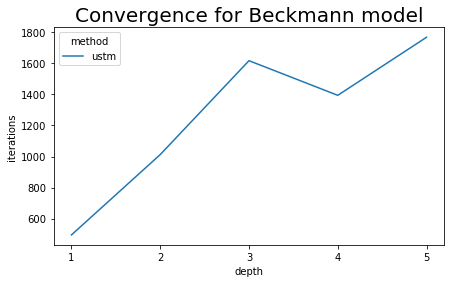

In [33]:
plt.figure(figsize=(7,4))
plt.title('Convergence for Beckmann model', fontsize=20)
eps_upper = 1e4
for method, data in results.items():
    x = depths
    y = np.array(avg_iters)
    
    plt.plot(x, y, label = method)
plt.legend(title = 'method')
plt.xticks(x)
plt.xlabel(r'depth')
plt.ylabel('iterations')
plt.show()

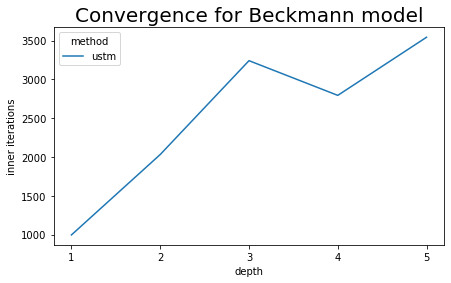

In [34]:
plt.figure(figsize=(7,4))
plt.title('Convergence for Beckmann model', fontsize=20)
eps_upper = 1e4
for method, data in results.items():
    x = depths
    y = np.array(avg_inner_iters)
    
    plt.plot(x, y, label = method)
plt.legend(title = 'method')
plt.xticks(x)
plt.xlabel(r'depth')
plt.ylabel('inner iterations')
plt.show()